In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import gillespy2

In [4]:
import time
import numpy
import scipy.stats
from matplotlib import pyplot as plt
import pickle

In [5]:
sys.path.append('../test/')
import example_models

In [6]:
print(example_models.__all__)

['create_trichloroethylene', 'create_lac_operon', 'create_schlogl', 'create_michaelis_menten', 'create_decay', 'create_decay_no_tspan', 'create_tyson_2_state_oscillator', 'create_oregonator', 'create_vilar_oscillator', 'create_dimerization', 'create_degradation', 'create_robust_model', 'create_multi_firing_event', 'create_toggle_switch', 'create_telegraph_model']


In [7]:
all_model_names = ['create_decay',
 #'create_decay_no_tspan',
 #'create_degradation',
 'create_dimerization',
 #'create_lac_operon',
 'create_michaelis_menten',
 #'create_multi_firing_event',
 'create_opioid',
 #'create_oregonator',
 #'create_robust_model',
 'create_schlogl',
 #'create_telegraph_model',
 'create_toggle_switch',
 'create_trichloroethylene',
 'create_tyson_2_state_oscillator',
 'create_vilar_oscillator']

In [8]:
model = eval(f"example_models.{all_model_names[0]}")()
print(model.name)

Decay


In [9]:
result = model.run()

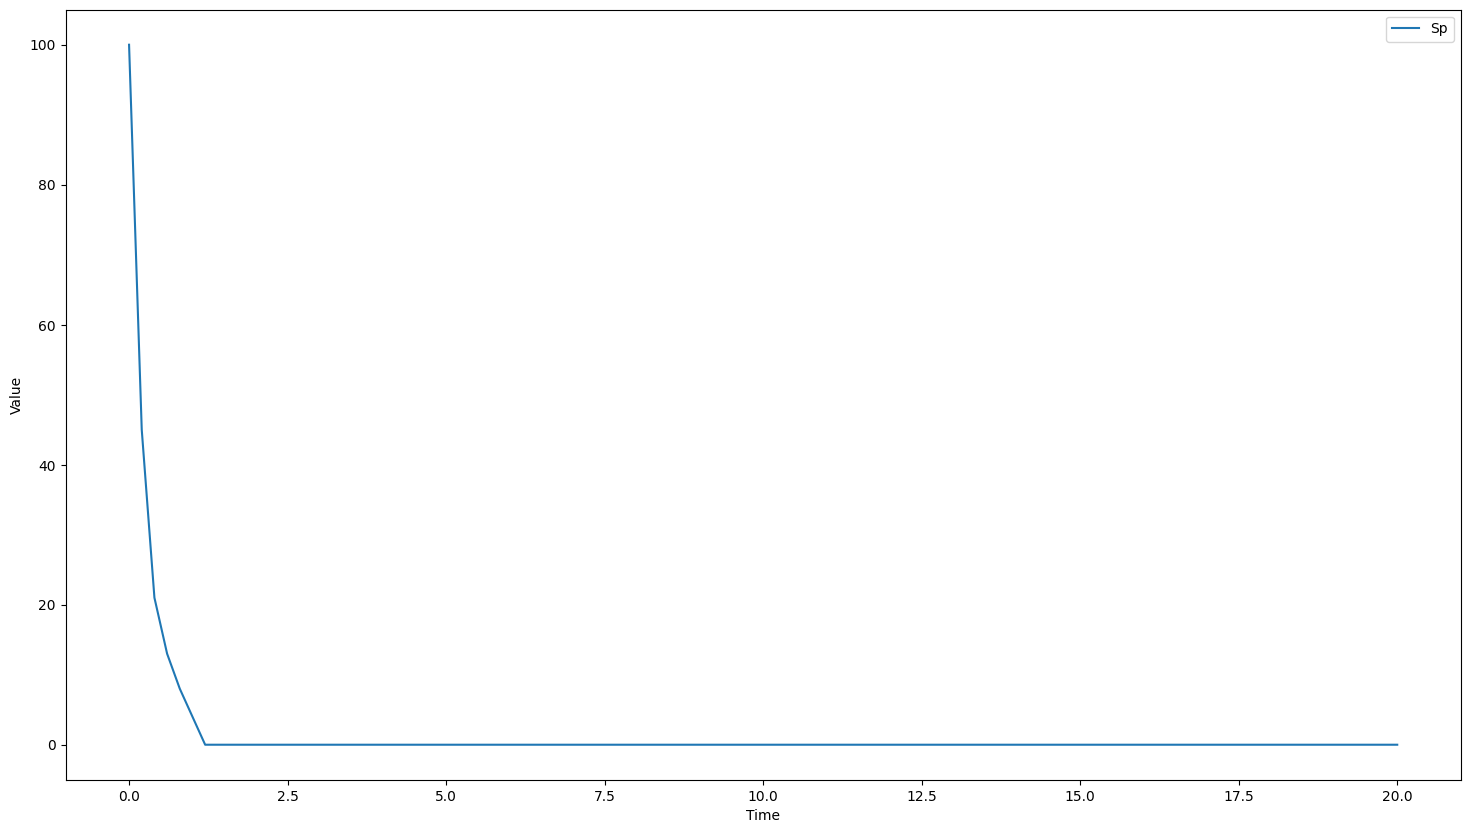

In [10]:
result.plot()

In [11]:
# for m in all_model_names:
#     tic = time.time()
#     print(f"{m} started at {tic}")
#     model = eval(f"example_models.{m}")()
#     result = model.run()
#     print(f"{m} complete in {time.time() - tic}")
#     result.plot()

In [12]:
model = eval(f"example_models.{all_model_names[2]}")()
print(model.name)

Michaelis_Menten


In [105]:
one_result = model.run()

[autoreload of _frozen_importlib failed: Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.8/importlib/__init__.py", line 166, in reload
    spec = module.__spec__ = _bootstrap._find_spec(name, pkgpath, target)
AttributeError: module 'importlib._bootstrap' has no attribute '_find_spec'
]
[autoreload of _frozen_importlib_external failed: Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(mo

[autoreload of urllib.parse failed: Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b

AttributeError: module 'linecache' has no attribute '_ipython_cache'

In [13]:
all_results={}
try:
    with open('all_results.p','rb') as fd:
        all_results = pickle.load(fd)
except FileNotFoundError: pass

In [14]:
all_solvers= [
gillespy2.SSACSolver,
gillespy2.NumPySSASolver,
gillespy2.TauLeapingCSolver,
gillespy2.TauLeapingSolver,
gillespy2.TauHybridCSolver,
gillespy2.TauHybridSolver,
]

In [16]:
print(model.name)
for solver in all_solvers:
    if solver.name in all_results:
        print(f"\tCached {solver.name}")
    else:
        print(f"\tRunning {solver.name}", end=' '*(20-len(solver.name)))
        tic = time.time()
        all_results[solver.name] = model.run(solver=solver, number_of_trajectories=1000)
        #all_results[solver.name].plot()
        print(f"\t\t{time.time()-tic}")

Michaelis_Menten
	Cached SSACSolver
	Cached NumPySSASolver
	Cached TauLeapingCSolver
	Cached TauLeapingSolver
	Cached TauHybridCSolver
	Cached TauHybridSolver


In [17]:
#with open('all_results.p','wb+') as fd:
#    pickle.dump(all_results,fd)

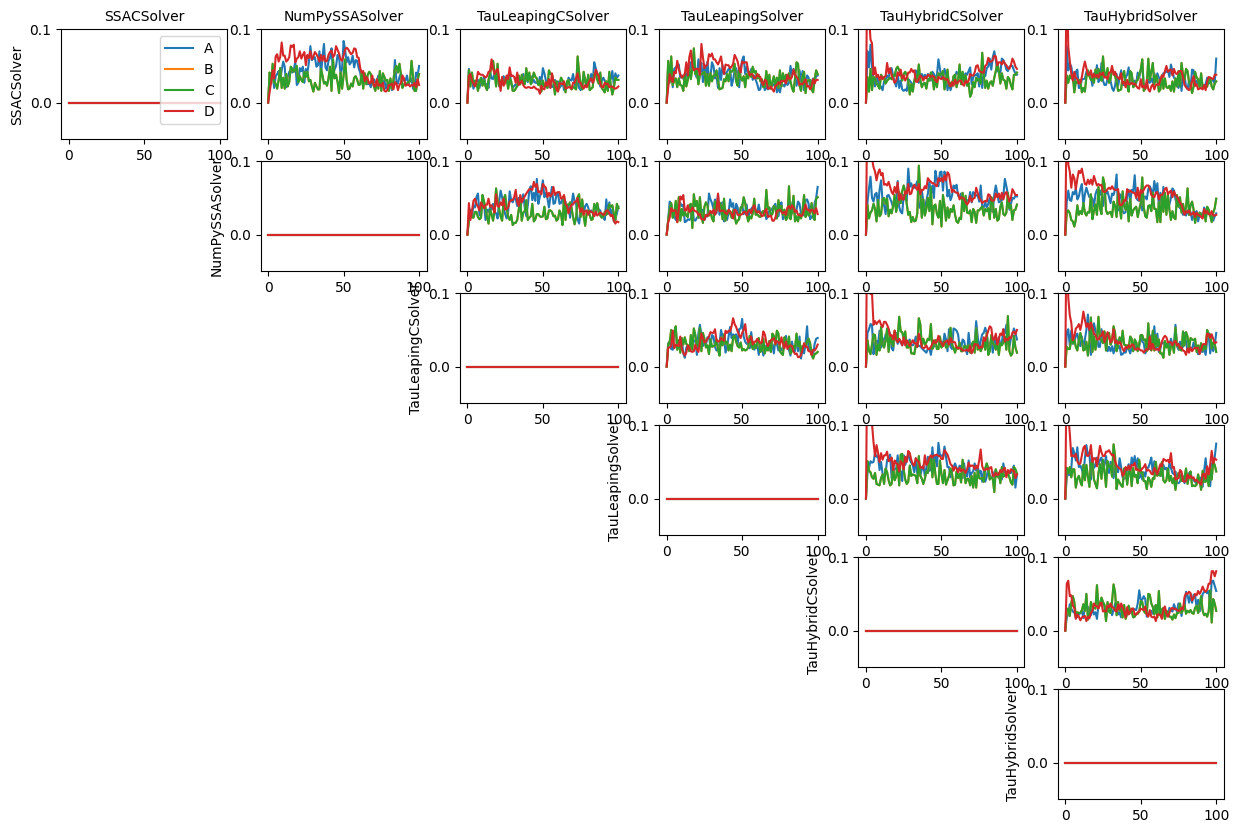

In [18]:
plt.figure(figsize=(15,10))
for ii in range(len(all_solvers)):
    s1 = all_solvers[ii].name
    for jj in range(ii,len(all_solvers)):
        #print(f"{ii},{jj}")
        plt.subplot(len(all_solvers),len(all_solvers),1+(ii*len(all_solvers)+jj))
        s2 = all_solvers[jj].name
        #print(f"{s1} <--ks_dist--> {s2}")
        for species in all_results[s1][0].keys():
            spec_dist = numpy.zeros((len(all_results[s1][0]['time'])))
            if species=='time':continue
            #print(species)
            for t_ndx,t in enumerate(all_results[s1][0]['time']):
                dist1 = numpy.zeros((len(all_results[s1])))
                for i,r in enumerate(all_results[s1]):
                    dist1[i] = r[species][t_ndx]
                dist2 = numpy.zeros((len(all_results[s2])))
                for i,r in enumerate(all_results[s2]):
                    dist2[i] = r[species][t_ndx]
                #print(f"t={t} \t{scipy.stats.ks_2samp(dist1,dist2).statistic}")
                spec_dist[t_ndx] = scipy.stats.ks_2samp(dist1,dist2).statistic
            plt.plot(all_results[s1][0]['time'],spec_dist,label=species)
            plt.ylim([-0.05, 0.1])
        if(ii+jj)==0: plt.legend(loc='best')
        if(ii==jj):plt.ylabel(s1, fontsize=10)
        if(ii==0): plt.title(s2, fontsize=10)
        
        

Based on the above plots, we can take the last 50% of the time points for each species and average everything into a single number.

# Show SSA Convergence as N->$\inf$

In [19]:
convergence_results = {}
try:
    with open('convergence_results.p','rb') as fd:
        convergence_results = pickle.load(fd)
except FileNotFoundError: pass
print(list(convergence_results.keys()))

[10.0, 1000.0, 100000.0, 100.0, 10000.0]


In [20]:
for Ntraj in [1e1, 1e2, 1e3, 1e4, 1e5]:
    if Ntraj not in convergence_results:
        convergence_results[Ntraj] = {}
    for solver in [gillespy2.NumPySSASolver,gillespy2.SSACSolver]:
        if solver.name not in convergence_results[Ntraj]: 
            convergence_results[Ntraj][solver.name] = {}
        for batch in ['A', 'B']:
            if batch in convergence_results[Ntraj][solver.name]: 
                print(f"cached  {Ntraj} {solver.name} {batch}")
            else:
                convergence_results[Ntraj][solver.name][batch] = {}
                ##
                print(f"running {Ntraj} {solver.name} {batch}", end='')
                tic = time.time()
                result = model.run(solver=solver, number_of_trajectories=int(Ntraj))
                print(f"\t\tdone in {time.time()-tic}")
                ##
                a = int(len(results[0]['time'])/2)
                b = len(results[0]['time'])
                dist = numpy.zeros((b-a,len(model.listOfSpecies),int(Ntraj)))
                #
                for s_ndx,species in enumerate(model.listOfSpecies):
                    for n_ndx in range(int(Ntraj)):
                        dist[:,s_ndx,n_ndx] = result[n_ndx][species][a:]
                #
                convergence_results[Ntraj][solver.name][batch] = dist


cached  10.0 NumPySSASolver A
cached  10.0 NumPySSASolver B
cached  10.0 SSACSolver A
cached  10.0 SSACSolver B
cached  100.0 NumPySSASolver A
cached  100.0 NumPySSASolver B
cached  100.0 SSACSolver A
cached  100.0 SSACSolver B
cached  1000.0 NumPySSASolver A
cached  1000.0 NumPySSASolver B
cached  1000.0 SSACSolver A
cached  1000.0 SSACSolver B
cached  10000.0 NumPySSASolver A
cached  10000.0 NumPySSASolver B
cached  10000.0 SSACSolver A
cached  10000.0 SSACSolver B
cached  100000.0 NumPySSASolver A
cached  100000.0 NumPySSASolver B
cached  100000.0 SSACSolver A
cached  100000.0 SSACSolver B


In [21]:
print(list(convergence_results.keys()))

[10.0, 1000.0, 100000.0, 100.0, 10000.0]


In [22]:
#with open('convergence_results.p','wb+') as fd:
#    pickle.dump(convergence_results,fd)

In [49]:
convergence_results_analysis={}
x_vals = sorted(convergence_results.keys())
#print(x_vals)
#NumPySSASolver-self
y1_vals = numpy.zeros(len(x_vals))
y1_errs = numpy.zeros(len(x_vals))
for y_ndx,Ntraj in enumerate(x_vals):
    d_sum = 0
    d_ssum = 0
    d_cnt = 0
    for s_ndx,species in enumerate(model.listOfSpecies):
        for t_ndx in range(convergence_results[Ntraj]['NumPySSASolver']['A'].shape[0]):
            d_cnt += 1
            val = scipy.stats.ks_2samp(
                        convergence_results[Ntraj]['NumPySSASolver']['A'][t_ndx,s_ndx,:],
                        convergence_results[Ntraj]['NumPySSASolver']['B'][t_ndx,s_ndx,:]
                                 ).statistic
            d_sum += val
            d_ssum += val*val
    y1_vals[y_ndx] = d_sum/d_cnt
    y1_errs[y_ndx] = d_ssum/d_cnt - (y1_vals[y_ndx]*y1_vals[y_ndx])
convergence_results_analysis['NumPySSASolver-self'] = (x_vals,y1_vals,y1_errs)
        
#SSACSolver-self
y2_vals = numpy.zeros(len(x_vals))
y2_errs = numpy.zeros(len(x_vals))
for y_ndx,Ntraj in enumerate(x_vals):
    d_sum = 0
    d_ssum = 0
    d_cnt = 0
    for s_ndx,species in enumerate(model.listOfSpecies):
        for t_ndx in range(convergence_results[Ntraj]['SSACSolver']['A'].shape[0]):
            d_cnt += 1
            val = scipy.stats.ks_2samp(
                        convergence_results[Ntraj]['SSACSolver']['A'][t_ndx,s_ndx,:],
                        convergence_results[Ntraj]['SSACSolver']['B'][t_ndx,s_ndx,:]
                                 ).statistic
            d_sum += val
            d_ssum += val*val
    y2_vals[y_ndx] = d_sum/d_cnt
    y2_errs[y_ndx] = d_ssum/d_cnt - (y2_vals[y_ndx]*y2_vals[y_ndx])
convergence_results_analysis['SSACSolver-self'] = (x_vals,y2_vals,y2_errs)

#NumPySSASolver-SSACSolver
y3_vals = numpy.zeros(len(x_vals))
y3_errs = numpy.zeros(len(x_vals))
for y_ndx,Ntraj in enumerate(x_vals):
    d_sum = 0
    d_ssum = 0
    d_cnt = 0
    for s_ndx,species in enumerate(model.listOfSpecies):
        for t_ndx in range(convergence_results[Ntraj]['SSACSolver']['A'].shape[0]):
            d_cnt += 1
            val = scipy.stats.ks_2samp(
                        convergence_results[Ntraj]['NumPySSASolver']['A'][t_ndx,s_ndx,:],
                        convergence_results[Ntraj]['SSACSolver']['A'][t_ndx,s_ndx,:]
                                 ).statistic
            d_sum += val
            d_ssum += val*val
    y3_vals[y_ndx] = d_sum/d_cnt
    y3_errs[y_ndx] = d_ssum/d_cnt - (y3_vals[y_ndx]*y3_vals[y_ndx])
convergence_results_analysis['NumPySSASolver-SSACSolver'] = (x_vals,y3_vals,y3_errs)


###


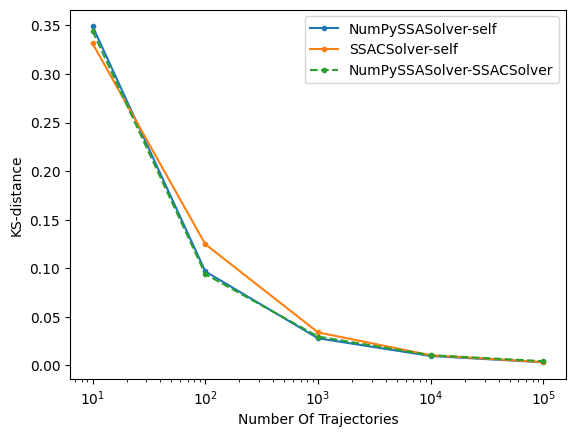

In [24]:
plt.semilogx(x_vals,y1_vals,'.-',label="NumPySSASolver-self")
plt.semilogx(x_vals,y2_vals,'.-',label="SSACSolver-self")
plt.semilogx(x_vals,y3_vals,'.--',label="NumPySSASolver-SSACSolver")
plt.ylabel("KS-distance")
plt.xlabel("Number Of Trajectories")
plt.legend(loc='best')

In [57]:
convergence_results_analysis['NumPySSASolver-self'][1][2]

0.02788235294117645

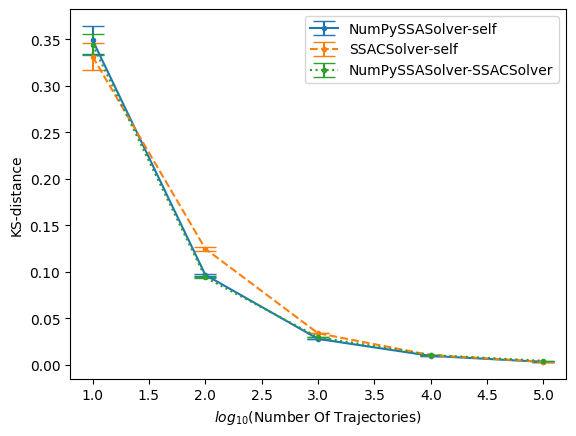

In [25]:
plt.errorbar(numpy.log10(x_vals),y1_vals,yerr=y1_errs,fmt='.-',capsize=8,label="NumPySSASolver-self")
plt.errorbar(numpy.log10(x_vals),y2_vals,yerr=y2_errs,fmt='.--',capsize=8,label="SSACSolver-self")
plt.errorbar(numpy.log10(x_vals),y3_vals,yerr=y3_errs,fmt='.:',capsize=8,label="NumPySSASolver-SSACSolver")
plt.ylabel("KS-distance")
plt.xlabel("$log_{10}$(Number Of Trajectories)")
_=plt.legend(loc='best')


From the above plot, we can see that 1e3 is a sufficient number of trajectories, and will run quickly

# Tau Stepsize Convergence

In [28]:
tau_convergence_results = {}
try:
    with open('tau_convergence_results.p','rb') as fd:
        tau_convergence_results = pickle.load(fd)
except FileNotFoundError: pass
print(list(tau_convergence_results.keys()))

[0, 0.1, 0.01]


In [102]:
#0==auto step size selection
tau_stepsize_values = [0, 1, 7.5e-1, 5e-1, 3.5e-1, 2e-1, 1e-1, 5e-2, 2.5e-2, 1e-2]  

Ntraj=1e3
tau_solvers = [gillespy2.TauHybridSolver, 
               #gillespy2.TauHybridCSolver,
               gillespy2.TauLeapingSolver,
               #gillespy2.TauLeapingCSolver,
              ]
for tau_stepsize in tau_stepsize_values:
    tau_stepsize_s=tau_stepsize
    if tau_stepsize==0: tau_stepsize_s='<auto>'
    if tau_stepsize not in tau_convergence_results:
        tau_convergence_results[tau_stepsize] = {}
    for solver in tau_solvers:
        if solver.name in tau_convergence_results[tau_stepsize]: 
            print(f"cached  {tau_stepsize_s} {solver.name}")
        else:
            ##
            print(f"running {tau_stepsize_s} {solver.name}", end='')
            tic = time.time()
            sol_obj = solver(model=model)
            if tau_stepsize==0:
                result = sol_obj.run(number_of_trajectories=int(Ntraj))
            else:
                result = sol_obj.run(number_of_trajectories=int(Ntraj),
                                    constant_tau_stepsize=tau_stepsize)
            print(f"\t\tdone in {time.time()-tic}")
            ##
            a = int(len(result[0]['time'])/2)
            b = len(result[0]['time'])
            dist = numpy.zeros((b-a,len(model.listOfSpecies),int(Ntraj)))
            #
            for s_ndx,species in enumerate(model.listOfSpecies):
                for n_ndx in range(int(Ntraj)):
                    dist[:,s_ndx,n_ndx] = result[n_ndx][species][a:]
            #
            tau_convergence_results[tau_stepsize][solver.name] = dist


cached  <auto> TauHybridSolver
running <auto> TauLeapingSolver		done in 54.5344820022583
cached  1 TauHybridSolver
running 1 TauLeapingSolver		done in 1.5941638946533203
cached  0.75 TauHybridSolver
running 0.75 TauLeapingSolver		done in 2.9258928298950195
cached  0.5 TauHybridSolver
running 0.5 TauLeapingSolver		done in 2.7288126945495605
cached  0.35 TauHybridSolver
running 0.35 TauLeapingSolver		done in 4.009900331497192
cached  0.2 TauHybridSolver
running 0.2 TauLeapingSolver		done in 6.260070085525513
cached  0.1 TauHybridSolver
running 0.1 TauLeapingSolver		done in 11.67253303527832
cached  0.05 TauHybridSolver
running 0.05 TauLeapingSolver		done in 19.847538471221924
cached  0.025 TauHybridSolver
running 0.025 TauLeapingSolver		done in 37.310598850250244
cached  0.01 TauHybridSolver
running 0.01 TauLeapingSolver		done in 84.96371078491211


In [103]:
print(sorted(list(tau_convergence_results.keys())))

[0, 0.01, 0.025, 0.05, 0.1, 0.2, 0.35, 0.5, 0.75, 1]


In [90]:
with open('tau_convergence_results.p','wb+') as fd:
    pickle.dump(tau_convergence_results,fd)

In [104]:
tau_convergence_results_analysis={}
x_vals = sorted(tau_convergence_results.keys())
#print(x_vals)
#TauHybridSolver(tau)-NumPySSASolver
y4_vals = numpy.zeros(len(x_vals))
y4_errs = numpy.zeros(len(x_vals))
for y_ndx,tau_stepsize in enumerate(x_vals):
    d_sum = 0
    d_ssum = 0
    d_cnt = 0
    for s_ndx,species in enumerate(model.listOfSpecies):
        for t_ndx in range(convergence_results[Ntraj]['NumPySSASolver']['A'].shape[0]):
            d_cnt += 1
            val = scipy.stats.ks_2samp(
                        convergence_results[Ntraj]['NumPySSASolver']['A'][t_ndx,s_ndx,:],
                        tau_convergence_results[tau_stepsize]['TauHybridSolver'][t_ndx,s_ndx,:]
                                 ).statistic
            d_sum += val
            d_ssum += val*val
    y4_vals[y_ndx] = d_sum/d_cnt
    y4_errs[y_ndx] = d_ssum/d_cnt - (y4_vals[y_ndx]*y4_vals[y_ndx])
tau_convergence_results_analysis['TauHybridSolver(tau)-NumPySSASolver'] = (x_vals,y4_vals,y4_errs)
# ####
# y5_vals = numpy.zeros(len(x_vals))
# y5_errs = numpy.zeros(len(x_vals))
# for y_ndx,tau_stepsize in enumerate(x_vals):
#     d_sum = 0
#     d_ssum = 0
#     d_cnt = 0
#     for s_ndx,species in enumerate(model.listOfSpecies):
#         for t_ndx in range(convergence_results[Ntraj]['NumPySSASolver']['A'].shape[0]):
#             d_cnt += 1
#             val = scipy.stats.ks_2samp(
#                         convergence_results[Ntraj]['NumPySSASolver']['A'][t_ndx,s_ndx,:],
#                         tau_convergence_results[tau_stepsize]['TauHybridCSolver'][t_ndx,s_ndx,:]
#                                  ).statistic
#             d_sum += val
#             d_ssum += val*val
#     y5_vals[y_ndx] = d_sum/d_cnt
#     y5_errs[y_ndx] = d_ssum/d_cnt - (y5_vals[y_ndx]*y5_vals[y_ndx])
# tau_convergence_results_analysis['TauHybridCSolver(tau)-NumPySSASolver'] = (x_vals,y5_vals,y5_errs)
####
y6_vals = numpy.zeros(len(x_vals))
y6_errs = numpy.zeros(len(x_vals))
for y_ndx,tau_stepsize in enumerate(x_vals):
    d_sum = 0
    d_ssum = 0
    d_cnt = 0
    for s_ndx,species in enumerate(model.listOfSpecies):
        for t_ndx in range(convergence_results[Ntraj]['NumPySSASolver']['A'].shape[0]):
            d_cnt += 1
            val = scipy.stats.ks_2samp(
                        convergence_results[Ntraj]['NumPySSASolver']['A'][t_ndx,s_ndx,:],
                        tau_convergence_results[tau_stepsize]['TauLeapingSolver'][t_ndx,s_ndx,:]
                                 ).statistic
            d_sum += val
            d_ssum += val*val
    y6_vals[y_ndx] = d_sum/d_cnt
    y6_errs[y_ndx] = d_ssum/d_cnt - (y6_vals[y_ndx]*y6_vals[y_ndx])
tau_convergence_results_analysis['TauLeapingSolver(tau)-NumPySSASolver'] = (x_vals,y6_vals,y6_errs)
####
# y7_vals = numpy.zeros(len(x_vals))
# y7_errs = numpy.zeros(len(x_vals))
# for y_ndx,tau_stepsize in enumerate(x_vals):
#     d_sum = 0
#     d_ssum = 0
#     d_cnt = 0
#     for s_ndx,species in enumerate(model.listOfSpecies):
#         for t_ndx in range(convergence_results[Ntraj]['NumPySSASolver']['A'].shape[0]):
#             d_cnt += 1
#             val = scipy.stats.ks_2samp(
#                         convergence_results[Ntraj]['NumPySSASolver']['A'][t_ndx,s_ndx,:],
#                         tau_convergence_results[tau_stepsize]['TauLeapingCSolver'][t_ndx,s_ndx,:]
#                                  ).statistic
#             d_sum += val
#             d_ssum += val*val
#     y7_vals[y_ndx] = d_sum/d_cnt
#     y7_errs[y_ndx] = d_ssum/d_cnt - (y7_vals[y_ndx]*y7_vals[y_ndx])
# tau_convergence_results_analysis['TauLeapingCSolver(tau)-NumPySSASolver'] = (x_vals,y7_vals,y7_errs)


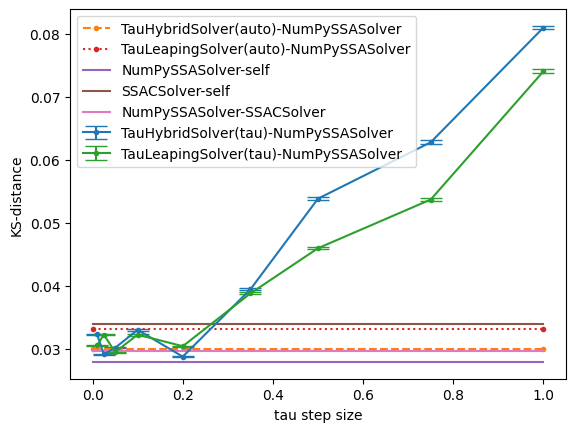

In [105]:
plt.errorbar(x_vals[1:],y4_vals[1:],yerr=y4_errs[1:],fmt='.-',capsize=8,label="TauHybridSolver(tau)-NumPySSASolver")
plt.plot([0,max(x_vals)],[y4_vals[0],y4_vals[0]],'.--',label="TauHybridSolver(auto)-NumPySSASolver")

#plt.errorbar(x_vals[1:],y5_vals[1:],yerr=y5_errs[1:],fmt='.-',capsize=8,label="TauHybridCSolver(tau)-NumPySSASolver")
#plt.plot([0,max(x_vals)],[y5_vals[0],y5_vals[0]],'.:',label="TauHybridCSolver(auto)-NumPySSASolver")

plt.errorbar(x_vals[1:],y6_vals[1:],yerr=y6_errs[1:],fmt='.-',capsize=8,label="TauLeapingSolver(tau)-NumPySSASolver")
plt.plot([0,max(x_vals)],[y6_vals[0],y6_vals[0]],'.:',label="TauLeapingSolver(auto)-NumPySSASolver")


ssa1_self = convergence_results_analysis['NumPySSASolver-self'][1][2]
plt.plot([0,max(x_vals)],[ssa1_self, ssa1_self], label='NumPySSASolver-self')
ssa2_self = convergence_results_analysis['SSACSolver-self'][1][2]
plt.plot([0,max(x_vals)],[ssa2_self, ssa2_self], label='SSACSolver-self')
ssa3_self = convergence_results_analysis['NumPySSASolver-SSACSolver'][1][2]
plt.plot([0,max(x_vals)],[ssa3_self, ssa3_self], label='NumPySSASolver-SSACSolver')


plt.ylabel("KS-distance")
plt.xlabel("tau step size")
_=plt.legend(loc='best')
